Adapted from https://keras.io/applications/.

Install the packages.

In [1]:
# Might need to use conda to install tensorflow instead. Pip didn't work well for me.
!pip install tensorflow
!pip install keras

In [2]:
# Dirty fix for using pydot and graphviz
!pip install pydot
!pip install graphviz

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
import numpy as np
import tensorflow as tf

Download the data from http://download.tensorflow.org/example_images/flower_photos.tgz and decompress it to the right path (Running with ! in jupyter had issues on my machine). Note that this will take a while.
`curl -LO http://download.tensorflow.org/example_images/flower_photos.tgz`


The data is arranged manually like this:
<img src=attachment:image.png width="100" align="left" />
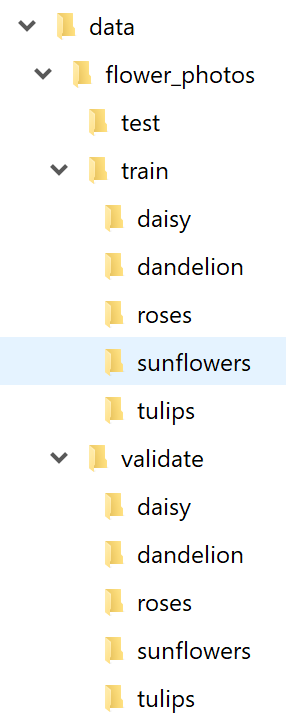

We first define some parameters.

In [4]:
# dimensions of our images. 
img_width, img_height = 224, 224 
train_data_dir = 'data/flower_photos/train' 
val_data_dir = 'data/flower_photos/validate' 
#nb_train_samples = [573, 808, 581, 629, 719] # I counted the numbers manually...
#nb_val_samples = [60, 90, 60, 70, 80] 
epochs = 5 # about 3-5 min per epoch on cpu without multi-threading
batch_size = 32
steps_per_epoch = 25
val_step = 3

In [5]:
class_names = ['rose', 'tulip', 'daisy', 'dandelion', 'sunflower']
class_names = sorted(class_names) # Sorting them

def prob_to_class(class_names, probs):
    return dict(zip(class_names, probs.ravel().tolist()))

Exercise 1: Let's play with the original Inception v3 model.

In [6]:
#load the full InceptionV3 model
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights='imagenet', include_top=True)

Using TensorFlow backend.


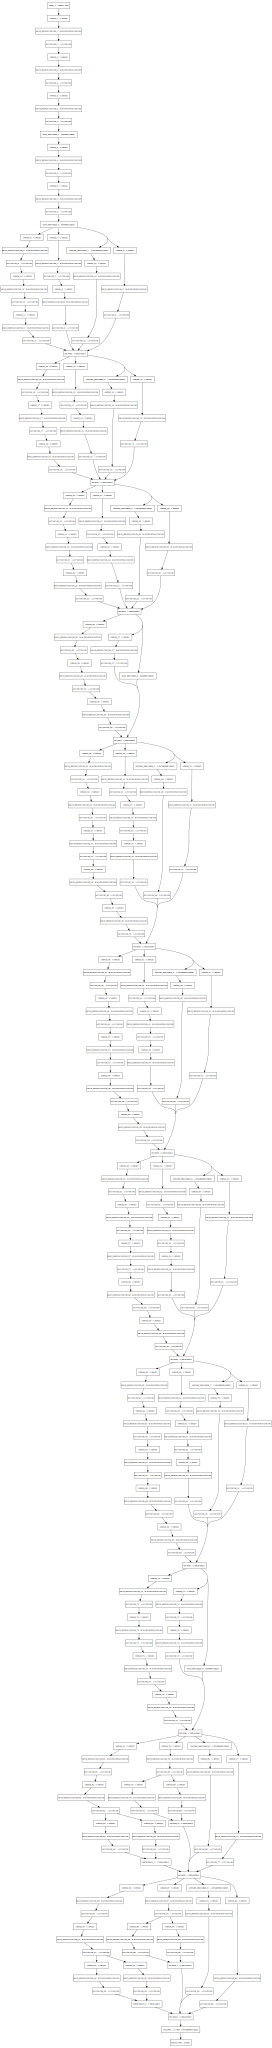

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
#test on one image
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

def test_one_image(img_path, target_w, target_h, model):
    img = image.load_img(img_path, target_size=(target_w, target_h))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    return preds

In [9]:
result = test_one_image('data/flower_photos/test/1.jpg', img_width, img_height, model)
print('Predicted:', decode_predictions(result))

Predicted: [[('n11939491', 'daisy', 0.96190333), ('n03991062', 'pot', 0.0200659), ('n04522168', 'vase', 0.016221913), ('n03482405', 'hamper', 0.0005655474), ('n07930864', 'cup', 0.00050525006)]]


In [10]:
result = test_one_image('data/flower_photos/test/2.jpg', img_width, img_height, model)
print('Predicted:', decode_predictions(result))

Predicted: [[('n11939491', 'daisy', 0.9818465), ('n02206856', 'bee', 0.014384883), ('n04522168', 'vase', 0.0026059696), ('n02727426', 'apiary', 0.00013770521), ('n02877765', 'bottlecap', 0.000117173106)]]


Exercise 2: Use transfer learning to retrain the model for flowers

In [11]:
# create the base pre-trained model
from keras.layers import Input, Dense, GlobalAveragePooling2D

base_model = InceptionV3(include_top=False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 5 classes
predictions = Dense(5, activation='softmax')(x)

In [12]:
# prepare training and validation dataset
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = datagen.flow_from_directory(
    train_data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 3310 images belonging to 5 classes.
Found 360 images belonging to 5 classes.


In [13]:
# this is the model we will train
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard
from keras import metrics

new_model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                  metrics=[metrics.mae, metrics.categorical_accuracy])

callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto'), 
             TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)]

# train the model on the new data for a few epochs
history = new_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                                  callbacks=callbacks, verbose=1,
                                  validation_data=val_generator, validation_steps=val_step)

new_model.save_weights('first_try.h5')  # always save your weights after training or during training


Epoch 1/5
25/25 [==============================] - 169s 7s/step - loss: 3.2702 - mean_absolute_error: 0.2473 - categorical_accuracy: 0.4262 - val_loss: 2.1524 - val_mean_absolute_error: 0.2195 - val_categorical_accuracy: 0.4375
Epoch 2/5
25/25 [==============================] - 162s 6s/step - loss: 1.2289 - mean_absolute_error: 0.1954 - categorical_accuracy: 0.5887 - val_loss: 3.0867 - val_mean_absolute_error: 0.2443 - val_categorical_accuracy: 0.3854


The training will take a while. We can use tensorboard --logdir=./logs to visualize the training process. It seems that it starts to overfit around epoch 3. We can enable early stopping.

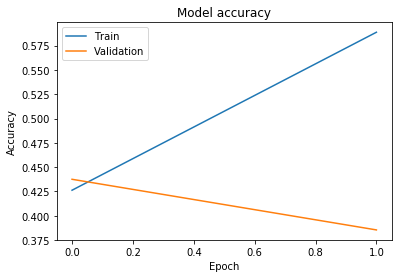

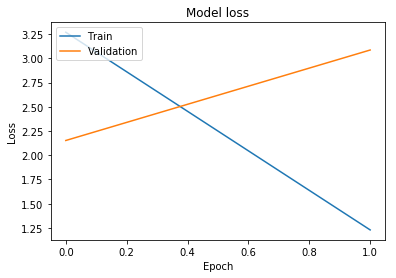

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
result = test_one_image('data/flower_photos/test/1.jpg', img_width, img_height, new_model)
print('Predicted:', prob_to_class(class_names, result))

Predicted: {'daisy': 0.9871869087219238, 'dandelion': 5.3793169172422495e-06, 'rose': 0.00023248314391821623, 'sunflower': 0.012393863871693611, 'tulip': 0.00018117274157702923}


In [18]:
result = test_one_image('data/flower_photos/test/3.jpg', img_width, img_height, new_model)
print('Predicted:', prob_to_class(class_names, result))

Predicted: {'daisy': 0.002196474000811577, 'dandelion': 6.406191459973343e-06, 'rose': 2.4868750188034028e-05, 'sunflower': 0.9020262956619263, 'tulip': 0.09574603289365768}


Exercise 3: Now we will use the same data to fine tue the model.

In [19]:
# At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. 
# We will freeze the bottom N layers and train the remaining top layers.

fine_tune_model = Model(inputs=base_model.input, outputs=predictions)

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze the first 172 layers and unfreeze the rest:
layer_split_idx = 172

for layer in new_model.layers[:layer_split_idx]:
   layer.trainable = False
for layer in new_model.layers[layer_split_idx:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD

fine_tune_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',
                        metrics=[metrics.mae, metrics.categorical_accuracy])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = fine_tune_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                                         callbacks=callbacks, verbose=1,
                                         validation_data=val_generator, validation_steps=val_step)

fine_tune_model.save_weights('fine_tune.h5')  # always save your weights after training or during training

Epoch 1/5
 9/25 [=========>....................] - ETA: 2:25 - loss: 1.1550 - mean_absolute_error: 0.1867 - categorical_accuracy: 0.6076

In [ ]:
# Plot training & validation accuracy values
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
result = test_one_image('data/flower_photos/test/1.jpg', img_width, img_height, fine_tune_model)
print('Predicted:', prob_to_class(class_names, result))

In [ ]:
result = test_one_image('data/flower_photos/test/2.jpg', img_width, img_height, fine_tune_model)
print('Predicted:', prob_to_class(class_names, result))

In [ ]:
from keras.utils import print_summary
print_summary(fine_tune_model)